In [1]:
#!pip install tf-keras-vis

In [2]:
print("Executing : Load libraries")

import os
# uncomment to force the non use of GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

from keras.utils import load_img

from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.saliency import Saliency

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

path_project_root = os.path.dirname(os.path.abspath(''))

Executing : Load libraries
Tensorflow recognized 0 GPUs


# SALIENCY

In [3]:
def load_model(model_name="MobileNetV2"):
    """
        Return the selected model. Argument : name of the model.
    """
    print("Executing : Load Model")
    model=""
    if model_name=="VGG16":
        from keras.applications.vgg16 import VGG16 as Model
        model = Model(weights='imagenet', include_top=True)
    elif model_name=="MobileNetV2":
        from keras.applications.mobilenet_v2 import MobileNetV2 as Model
        model = Model(weights='imagenet', include_top=True)
    else:
        print("Error : model not available")
        raise NameError()
    return model

def get_image(path, size=(224,224), model_name="MobileNetV2"):
    print("Executing : Load And Preprocess Image")
    image= load_img(path, target_size=size)
    image = tf.cast(image, tf.float32)
    if model_name=="VGG16":
        image = tf.keras.applications.vgg16.preprocess_input(image)
    elif model_name=="MobileNetV2":
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

def get_score_function(index_list):
    print("Executing : Create Score Function")
    return CategoricalScore(index_list)

def get_saliency_object(model):
    print("Executing : Create Saliency Object")
    replace2linear = ReplaceToLinear()
    saliency = Saliency(model, model_modifier=replace2linear, clone=True)
    return saliency

# ATTACK

In [4]:
def get_attacked_image(image):

    pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
    pretrained_model.trainable = False

    # ImageNet labels
    decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    #image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]

    image_probs = pretrained_model.predict(image)

    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
    _, image_class, class_confidence = decode_predictions(image_probs, top=1)[0][0]
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.show()

    loss_object = tf.keras.losses.CategoricalCrossentropy()

    image_index = 413 #goldfish = 1; brown bear = 294; assault rifle = 413
    label = tf.one_hot(image_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    plt.figure()

    with tf.GradientTape() as tape:
      tape.watch(image)
      prediction = pretrained_model(image)
      loss = loss_object(label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    perturbations = signed_grad
    plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]
    plt.show()

    epsilons = [0, 0.01, 0.1, 0.15]
    descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]
    
    #for i, eps in enumerate(epsilons):
    adv_x = image + epsilons[3]*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, label, confidence = decode_predictions(pretrained_model.predict(adv_x), top=1)[0][0]
    plt.figure()
    plt.imshow(adv_x[0]*0.5+0.5)
    im = np.array(adv_x[0]*0.5 + 0.5)
    # plt.imsave(os.path.join(path_project_root, 'attack_and_saliency\images\image_attacked.png'), im) #Endroit où sauvegarder l'image attaqué (Changer le path si besoin)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[3], label, confidence*100))
    plt.show()

    attacked_image = im
    return attacked_image

# Metric

In [5]:
import numpy as np
import cv2
from scipy.stats import pearsonr
from skimage.metrics import structural_similarity as ssim

# Ouvrir les cartes de saillance
def img_open(path_sal_map,path_attacked_sal_map):
    img1 = cv2.imread(path_sal_map)
    img2 = cv2.imread(path_attacked_sal_map)
    return img1,img2

# Calcul de la différence absolue
# Plus la valeur est proche de 0 plus les images sont similaires
def diff_abs(path_sal_map,path_attacked_sal_map):
    img1, img2 = img_open(path_sal_map,path_attacked_sal_map)
    return np.sum(np.abs(img1 - img2))

# Calcul de la différence quadratique (mse)
# Plus la valeur est proche de 0 plus les images sont similaires
def diff_quadratique(path_sal_map,path_attacked_sal_map):
    img1, img2 = img_open(path_sal_map,path_attacked_sal_map)
    return np.sum(np.square(img1 - img2))

# Calcul du coef de corrélation
# Plus la valeur est proche de 1 plus les images sont similaires
def coef_correlation(path_sal_map,path_attacked_sal_map):
    img1, img2 = img_open(path_sal_map,path_attacked_sal_map)
    result = pearsonr(img1.flatten(),img2.flatten())
    return result.statistic

# Calcul du ssim Structural Similarity Index
# Plus la valeur est proche de 1 plus les images sont similaires
def ssim_func(path_sal_map,path_attacked_sal_map):
    img1 = cv2.imread(path_sal_map)
    img2 = cv2.imread(path_attacked_sal_map)
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    valssim = ssim(gray_img1, gray_img2)
    return valssim


# MAIN PROGRAM

Executing : Load Model
Executing : Load And Preprocess Image
Executing : Create Score Function
Executing : Create Saliency Object
Executing : Calculating Saliency Image


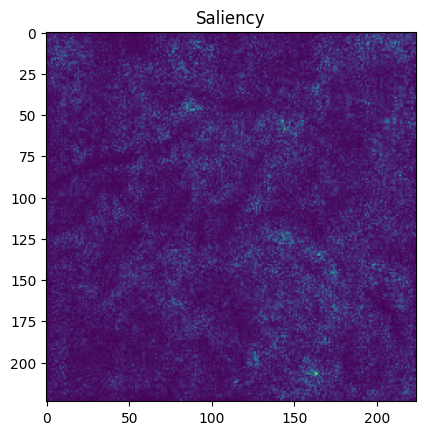

Executing : Calculating Smooth Saliency Image


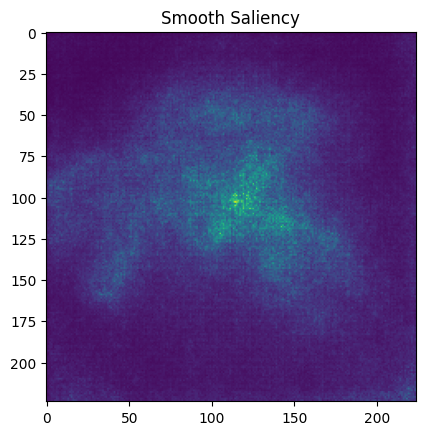

In [6]:
image_title = 'Goldfish'
index_model = [1]
path = os.path.join(path_project_root, "adversarial\images\output\PGD\goldfishPGD.png") #path vers l'image d'origine

model = load_model("MobileNetV2")
image = get_image(path, model_name="MobileNetV2")
score = get_score_function(index_model)
saliency = get_saliency_object(model)

print("Executing : Calculating Saliency Image")
saliency_image = saliency(score, image)[0]
plt.imsave(os.path.join(path_project_root, 'attack_and_saliency\images\saliency.png'), saliency_image)
plt.imshow(saliency_image)
plt.title("Saliency")
plt.show()

print("Executing : Calculating Smooth Saliency Image")
smooth_saliency_image = saliency(score, image, smooth_samples=20, smooth_noise=0.20)[0]
plt.imshow(smooth_saliency_image)
plt.title("Smooth Saliency")
plt.show()

## Attack image

1/1 [==============================] - 1s 632ms/step


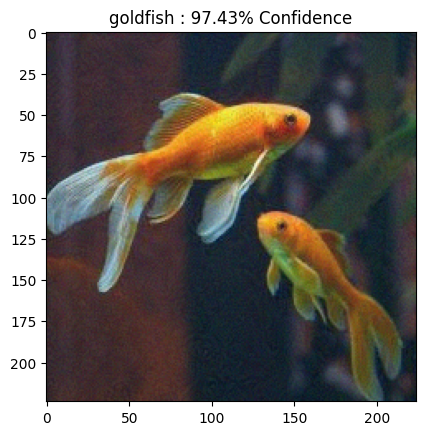

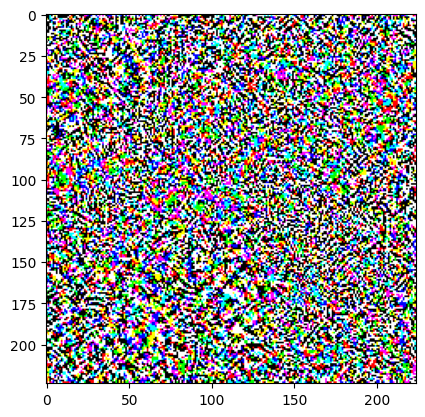

1/1 [==============================] - 0s 37ms/step


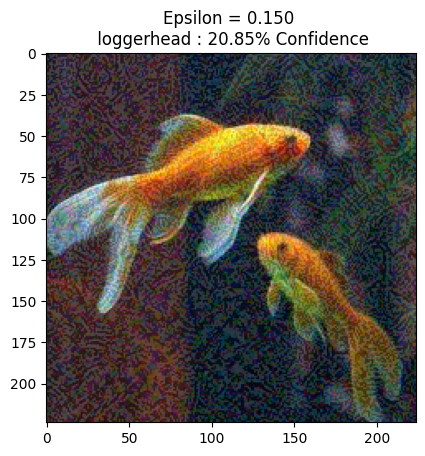

In [7]:
attacked_image = get_attacked_image(image)

## Saliency

Executing : Calculating Saliency Image


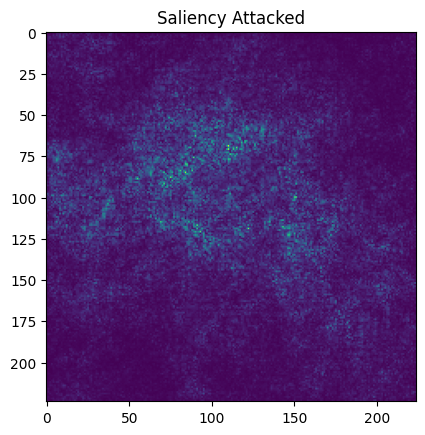

Executing : Calculating Smooth Saliency Image


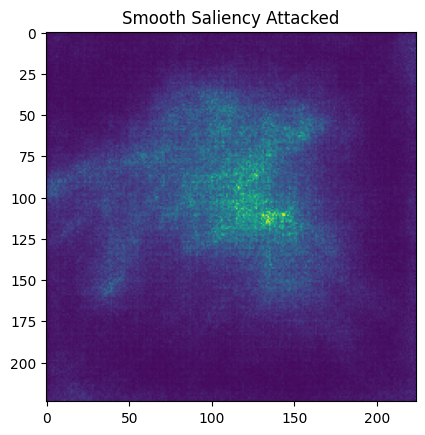

In [10]:
print("Executing : Calculating Saliency Image")
saliency_attacked_image = saliency(score, attacked_image)[0]
plt.imsave(os.path.join(path_project_root, 'attack_and_saliency\images\\attacked_saliency.png'), saliency_attacked_image)
plt.imshow(saliency_attacked_image)
plt.title("Saliency Attacked")
plt.show()

print("Executing : Calculating Smooth Saliency Image")
smooth_saliency_attacked_image = saliency(score, attacked_image, smooth_samples=20, smooth_noise=0.20)[0]
plt.imshow(smooth_saliency_attacked_image)
plt.title("Smooth Saliency Attacked")
plt.show()

## Metric

In [14]:
path_sal_map = os.path.join(path_project_root, 'attack_and_saliency\images\saliency.png')
path_attacked_sal_map = os.path.join(path_project_root, 'attack_and_saliency\images\attacked_saliency.png')

# difference metric
diff_abs = diff_abs(path_sal_map,path_attacked_sal_map)
diff_quadratique = diff_quadratique(path_sal_map,path_attacked_sal_map)
coef_correlation = coef_correlation(path_sal_map,path_attacked_sal_map)
ssim_func = ssim_func(path_sal_map,path_attacked_sal_map)

print("Différence absolue : ", diff_abs)
print("Différence quadratique : ", diff_quadratique)
print("Coefficient de corrélation : ", coef_correlation)
print("SSIM function : ", ssim_func)

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'